# Building regularized softmax regression model for CIFAR10 using PyTorch

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import top_k_accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# The CIFAR10 dataset
- Download and normalize the CIFAR10 dataset from torchvision
- Split the CIFAR10 data into train, validation and test set
- Set the batch size for processing these datasets
- Build the dataloaders for train, validation, and test set which will be used in the training loop
- Define the string class labels (targets are numeric 0-9)

In [ ]:
# mean and std for the RGB channels in CIFAR10
tmean = [0.49139968, 0.48215841, 0.44653091]
tstd = [0.24703223, 0.24348513, 0.26158784]

# transform the 32x32x3 images into a tensor after normalizing
# each channel using the parameters above
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tmean, tstd)])

# download and transform the  trainset and testset for training
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

#split trainset into a train and a val set (90-10 split)
lengths = [int(p * len(trainset)) for p in [0.9,0.1]]
tr,v = torch.utils.data.random_split(trainset,lengths)
train_sampler = torch.utils.data.SubsetRandomSampler(tr.indices)
val_sampler = torch.utils.data.SubsetRandomSampler(v.indices)

# set batch size and set up the data generators for train, val, test sets
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

print("Number of training batches = ",len(trainloader))
print("Number of validation batches = ",len(valloader))
print("Number of test batches = ",len(testloader))

# define the output classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:02<00:00, 67.9MB/s]


Number of training batches =  352
Number of validation batches =  40
Number of test batches =  79


# Visualize the training data

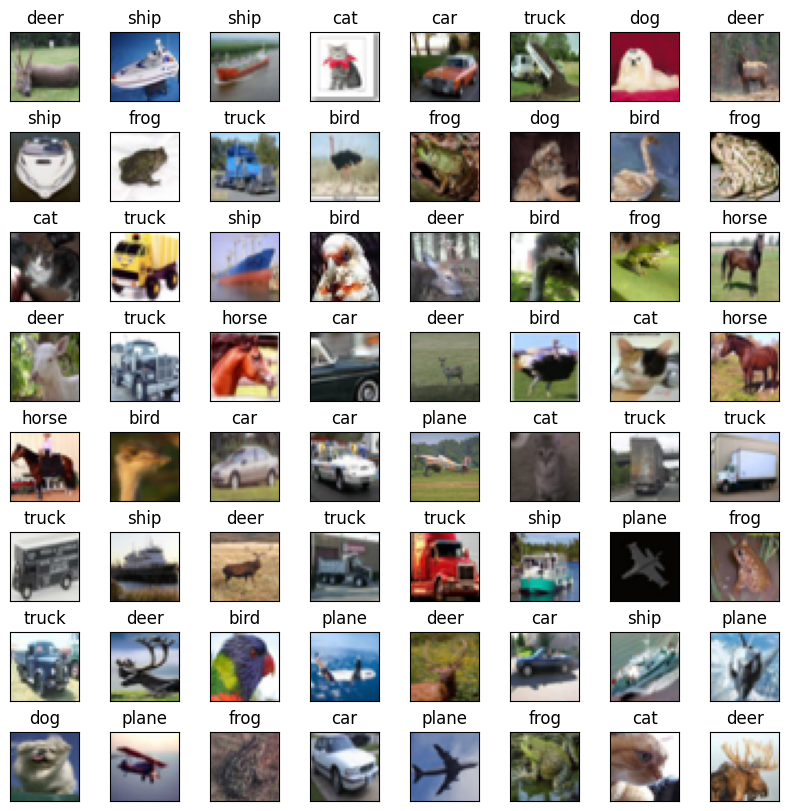

In [ ]:
Xtr,ytr = next(iter(trainloader))
# make a 8x8 grid and display 64 images from the first batch of training data
rows,cols = 8,8
fig = plt.figure(figsize=(8,8),constrained_layout=True)

for i in range(0,rows*cols):
    fig.add_subplot(rows,cols,i+1)
    tmp = np.transpose(Xtr[i].numpy(),(1,2,0))
    plt.imshow(((tmp*tstd + tmean)*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[ytr[i].numpy()])

# The softmax function

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition

# The SoftmaxRegression model (20 points)
- the __init__ function takes the number of inputs, number of outputs, a learning rate lr, and a weight decay wd (L2 regularization strength).
     - set the learning rate and weight decay of the model
     - build the network using torch.nn.Sequential() composed of the Flatten() function and a Linear() layer with num_inputs and num_outputs.
     - initialize the weights of the linear layer from a zero-mean Gaussian with noise=0.01. You can access the linear layer as self.net[1]
     - initialize the bias of the linear layer to be 0
     
- the forward function returns the softmax of the affine transform of the flattened input with the linear layer
- the loss function reshapes the prediction yhat and the true labels y into 1D tensors, and then calls the built in torch.nn.functional.cross_entropy() function to calculate the softmax loss with reduction = 'mean' if averaged is set to True.
- the predict function takes a batch of images X and runs the forward function to get the softmax, and return the index of the class with the highest probability (use .argmax())
- the configure_optimizers function that is a call to torch.optim.SGD() specifying the parameters to be updated, the weight decay, and the learning rate.


In [ ]:
class SoftmaxRegression(nn.Module):
    def __init__(self,num_inputs,num_outputs,lr, wd):
        super().__init__()
        # YOUR CODE HERE (about 5 lines)
        self.lr = lr
        self.wd = wd
        self.net = nn.Sequential(nn.Flatten(), nn.Linear(num_inputs, num_outputs))
        self.net[1].weight.data.normal_(0, 0.01)
        self.net[1].bias.data.fill_(0)

    def forward(self,X):
        # YOUR CODE HERE (1 line)
        return softmax(self.net(X))

    def loss(self,yhat,y,averaged=True):
        # YOUR CODE HERE (about 2-3 lines)
        yhat = yhat.reshape((-1, yhat.shape[-1]))
        y = y.reshape((-1))
        return F.cross_entropy(yhat, y, reduction='mean')

    def predict(self,X):
        # YOUR CODE HERE (1 line)
        return self.forward(X).argmax(dim=1)


    def configure_optimizers(self):
        # YOUR CODE HERE (1 line)
        return torch.optim.SGD(self.parameters(), weight_decay=self.wd, lr=self.lr)



# The training loop (50 points)

Complete the implementation of the function train_model which takes an initialized softmax model, a train set loader, a val set loader, and the number of epochs to train.

- Initialize train_loss and val_loss tensors to store the training set and val set losses for each epoch. We will plot them at the end
- Configure the optimizer associated with the model
- for each epoch until num_epochs do:
    - initialize a running train loss and a running val loss (so we can accumulate losses over each batch)
    - for each (X,y) in trainloader:
         - zero gradients in optimizer
         - compute output of model on X
         - compute loss on output and y
         - perform backward() step on loss
         - update parameters with optimizer.step()
         - accumulate running train loss with loss
    - set train loss for epoch to be running train loss/number of train set batches
    - with torch.no_grad() (do not update gradients during the evaluation on the val set)
         - for each (valX,valy) in valloader:
            - compute output of model on valX
            - compute loss on output and valy
            - accumulate running val loss with loss
    - set val loss for epoch to be running val loss/number of val batches
- Return model, train loss, val loss
    
If you are using a GPU, then remember to map X and y, as well as valX and valy, to the device, using to(device) method. If you wish, you can also implement early termination of the outer train loop when the val loss exceeds the train set loss a given number of times (say 10, or 20).

In [ ]:
def train_model(model,trainloader,valloader,num_epochs):
    # YOUR CODE HERE
    model.to(device)
    optimizer = model.configure_optimizers()
    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0

        model.train()
        total_train_batches = 0.0
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X)
            loss = model.loss(preds, y)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * X.size(0)
            total_train_batches += X.size(0)
        train_loss[epoch] = running_train_loss/total_train_batches

        model.eval()
        total_val_batches = 0.0
        with torch.no_grad():
            for valX,valy in valloader:
                valX, valy = valX.to(device), valy.to(device)
                vals = model(valX)
                vloss = model.loss(vals, valy)
                running_val_loss += vloss.item() * valX.size(0)
                total_val_batches += valX.size(0)
        val_loss[epoch] = running_val_loss/total_val_batches

    # END YOUR CODE HERE
    return model,train_loss,val_loss

# Test the training loop

> Add blockquote


- run this cell only after you have completed the function above.

Training model: 


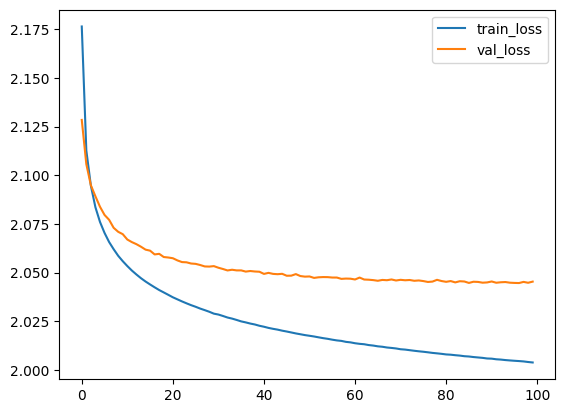

In [ ]:
# Run on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training model: ")

# set learning rate and weight decay
lr=1e-2
wd=1e-3
num_epochs = 100

model1 = SoftmaxRegression(3*32*32,10,lr=lr, wd=wd).to(device)
model1,train_loss,val_loss = train_model(model1,trainloader,valloader,num_epochs)
plt.plot(torch.arange(len(train_loss)),train_loss, label="train_loss")
plt.plot(torch.arange(len(val_loss)),val_loss, label="val_loss")
plt.legend()
plt.show()

# Build models for various learning rates and weight decays
- model2: lr=1e-3, wd=1e-3, num_epochs = 100
- model3: lr=1e-3, wd=1e-2, num_epochs = 100
- model4: lr=1e-1, wd=1e-2, num_epochs = 100
- model5: lr=1e-5, wd=1e-2, num_epochs = 100

Training model2 with learning rate 0.001 and weight decay 0.001: 


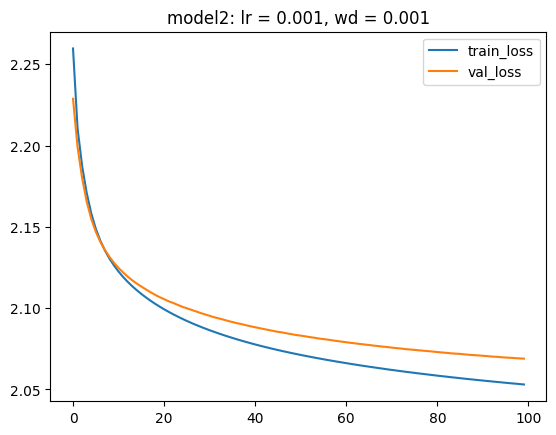

Training model3 with learning rate 0.001 and weight decay 0.01: 


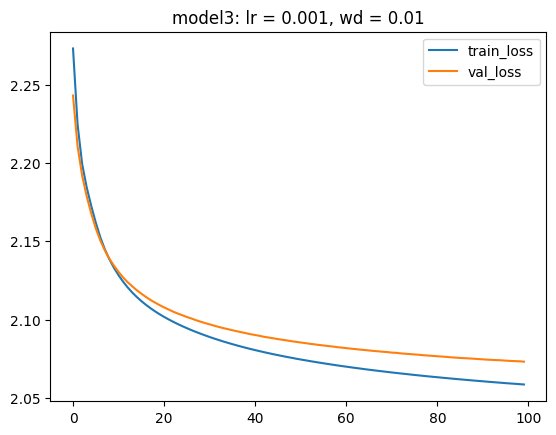

Training model4 with learning rate 0.1 and weight decay 0.01: 


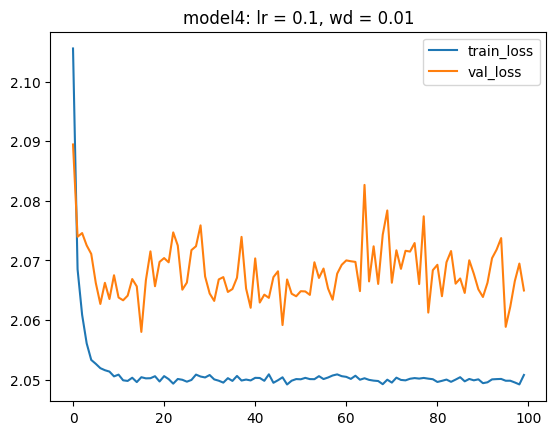

Training model5 with learning rate 1e-05 and weight decay 0.01: 


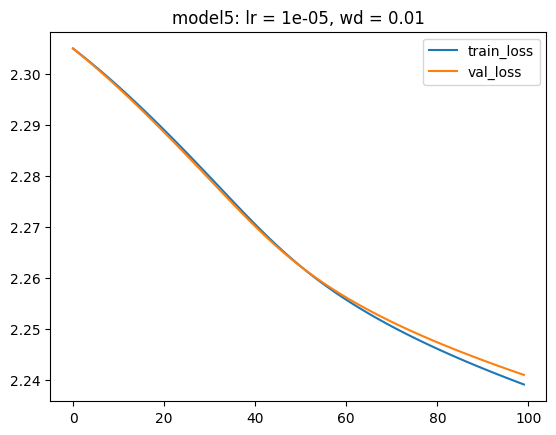

In [ ]:
num_epochs = 100
# YOUR CODE HERE to build model2, model3, model4, model5
models = [("model2", 1e-3, 1e-3), ("model3", 1e-3, 1e-2), ("model4", 1e-1, 1e-2), ("model5", 1e-5, 1e-2)]
trained_models = {}
for model_name, lr, wd in models:
    print(f"Training {model_name} with learning rate {lr} and weight decay {wd}: ")
    model = SoftmaxRegression(3*32*32,10,lr=lr, wd=wd).to(device)
    model, train_loss, val_loss = train_model(model, trainloader, valloader, num_epochs)
    trained_models[model_name] = model
    plt.plot(torch.arange(len(train_loss)),train_loss, label="train_loss")
    plt.plot(torch.arange(len(val_loss)),val_loss, label="val_loss")
    plt.legend()
    plt.title(f"{model_name}: lr = {lr}, wd = {wd}")
    plt.show()

# Evaluate the performance of models (20 points)
- for each model, use the sklearn metrics functions to calculate on the test set
     - confusion matrix
     - accuracy
     - classification report
- build the function getTopKAcc() to calculate top_k_accuracy using the sklearn top_k_accuracy_score function with k = 1,2,3

In [ ]:
# YOUR CODE to calculate CM, accuracy, classification report for model1,...,model5
def get_metrics(model, dataloader):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model.predict(X)
            predictions.append(preds)
            labels.append(y)

    all_predictions = torch.cat(predictions).cpu().numpy()
    all_labels = torch.cat(labels).cpu().numpy()

    acc_score = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    return acc_score, report, conf_matrix

print("Metrics for model1:")
acc_score, report, conf_matrix = get_metrics(model1, testloader)
print(f"Accuracy: {acc_score}")
print("Classification Report:")
print(report)
for model_name, model in trained_models.items():
    acc_score, report, conf_matrix = get_metrics(model, testloader)
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {acc_score}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)

Metrics for model1:
Accuracy: 0.4122
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.43      0.45      1000
           1       0.46      0.51      0.48      1000
           2       0.30      0.27      0.29      1000
           3       0.33      0.22      0.26      1000
           4       0.39      0.32      0.35      1000
           5       0.39      0.32      0.35      1000
           6       0.40      0.52      0.45      1000
           7       0.46      0.45      0.45      1000
           8       0.44      0.63      0.52      1000
           9       0.42      0.45      0.44      1000

    accuracy                           0.41     10000
   macro avg       0.41      0.41      0.41     10000
weighted avg       0.41      0.41      0.41     10000

Metrics for model2:
Accuracy: 0.4027
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.46      0.46      1000
           1

In [ ]:
def getTopKAcc(model,testloader,k=1):
    # YOUR CODE here to loop over the batches of test data to
    # calculate topK accuracy using the sklearn top_k_accuracy_score built in
    # remember to do all your work under torch.no_grad(), so that gradients of model are not updated!
    # return the top_k_accuracy score for the given model and test data set with the given k
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device), y.to(device)
            preds = model.forward(X).cpu().numpy()
            predictions.append(preds)
            labels.append(y.cpu().numpy())
        pred = np.vstack(predictions)
        label = np.hstack(labels)
        k_acc_score = top_k_accuracy_score(label, pred, k=k)
    return k_acc_score

In [ ]:
# YOUR CODE HERE to run the getTopKAcc function for testloader with the five models for k = 1,2,3
tk_accuracy1= getTopKAcc(model1, testloader, k=1)
tk_accuracy2= getTopKAcc(model1, testloader, k=2)
tk_accuracy3= getTopKAcc(model1, testloader, k=3)
print(f"the top {1} accuracy for model1 is {tk_accuracy1}")
print(f"the top {2} accuracy for model1 is {tk_accuracy2}")
print(f"the top {3} accuracy for model1 is {tk_accuracy3}")
for model_name, model in trained_models.items():
    top_k_accuracy_1 = getTopKAcc(model, testloader, k=1)
    print(f"the top {1} accuracy for {model_name} is {top_k_accuracy_1}")
    top_k_accuracy_2 = getTopKAcc(model, testloader, k=2)
    print(f"the top {2} accuracy for {model_name} is {top_k_accuracy_2}")
    top_k_accuracy_3 = getTopKAcc(model, testloader, k=3)
    print(f"the top {3} accuracy for {model_name} is {top_k_accuracy_3}")

the top 1 accuracy for model1 is 0.4122
the top 2 accuracy for model1 is 0.5913
the top 3 accuracy for model1 is 0.6894
the top 1 accuracy for model2 is 0.4027
the top 2 accuracy for model2 is 0.5648
the top 3 accuracy for model2 is 0.6707
the top 1 accuracy for model3 is 0.4012
the top 2 accuracy for model3 is 0.5643
the top 3 accuracy for model3 is 0.6703
the top 1 accuracy for model4 is 0.4017
the top 2 accuracy for model4 is 0.5674
the top 3 accuracy for model4 is 0.672
the top 1 accuracy for model5 is 0.2283
the top 2 accuracy for model5 is 0.3698
the top 3 accuracy for model5 is 0.5123


# Best performing model (10 points)
- what is the learning rate and weight decay associated with the best performing model?
- comment on the effect of changing learning rate and weight decay on the basis of the five models you have built.
- use the visualization code below to understand the structure of the learned models under the different hyperparameters. Do you see a pattern in the coefficients as a function of learning rate, weight decay? Explain.

# Visualizing the learned models

In [ ]:
# Visualize the learned weights for each class`

def visualize_model(model):
    theta = model.net[1].weight.data.cpu().numpy() # [10,3072]
    theta = theta.reshape(10, 3, 32, 32)  # Because we read the image as 3*32*32 instead of 32*32*3
    theta=np.transpose(theta, (0,2,3,1)) # [10,32,32,3], so plt can plot it

    theta_min, theta_max = np.min(theta), np.max(theta)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    plt.figure(figsize=(8,8))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        # Rescale the weights to be between 0 and 255
        thetaimg = 255.0 * (theta[i] - theta_min) / (theta_max - theta_min)
        plt.imshow(thetaimg.astype('uint8'),cmap='viridis')
        plt.axis('off')
        plt.title(classes[i])

    plt.tight_layout()
    plt.show()

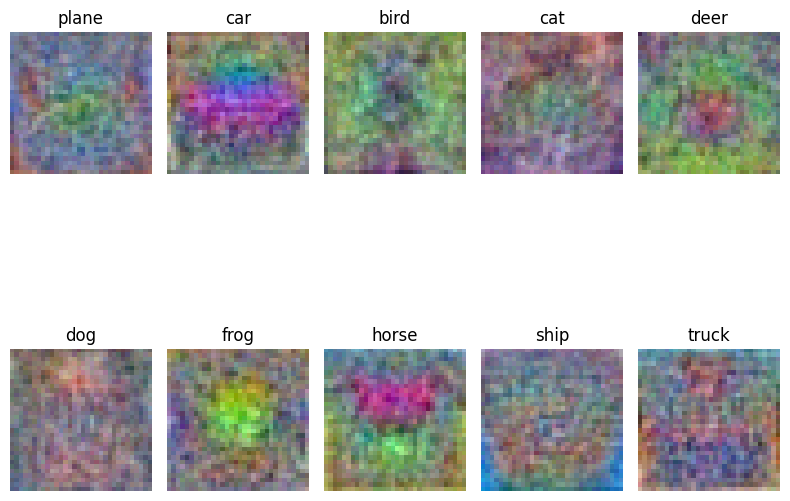

None
Visualizing weights for model2:


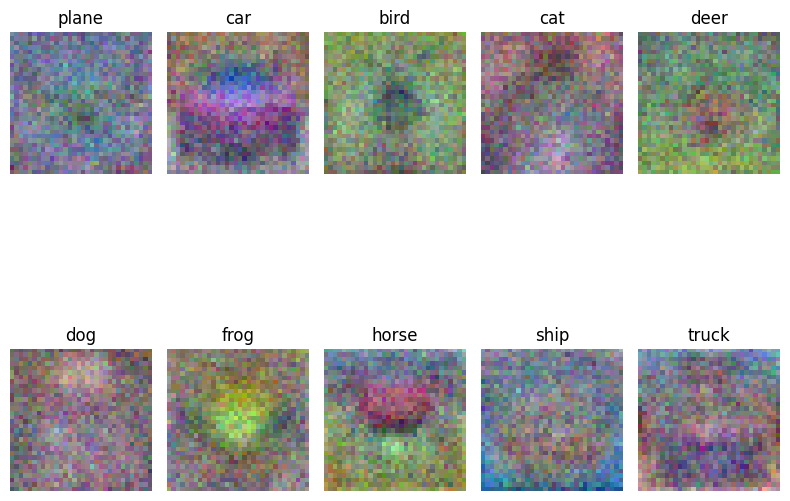

Visualizing weights for model3:


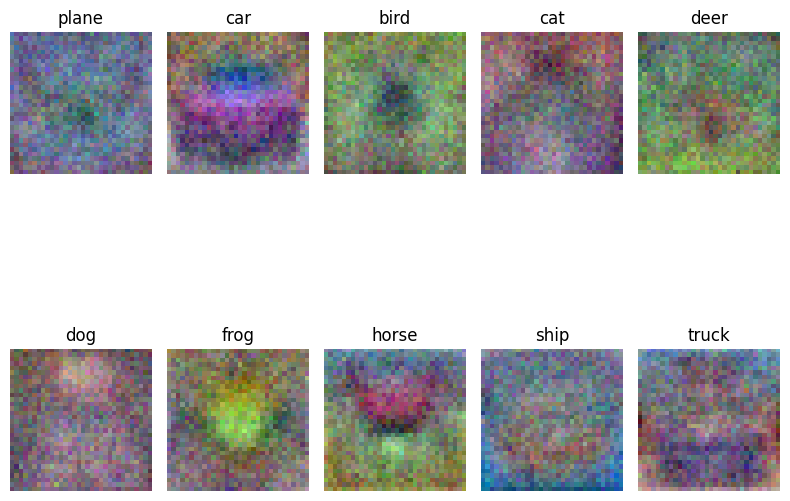

Visualizing weights for model4:


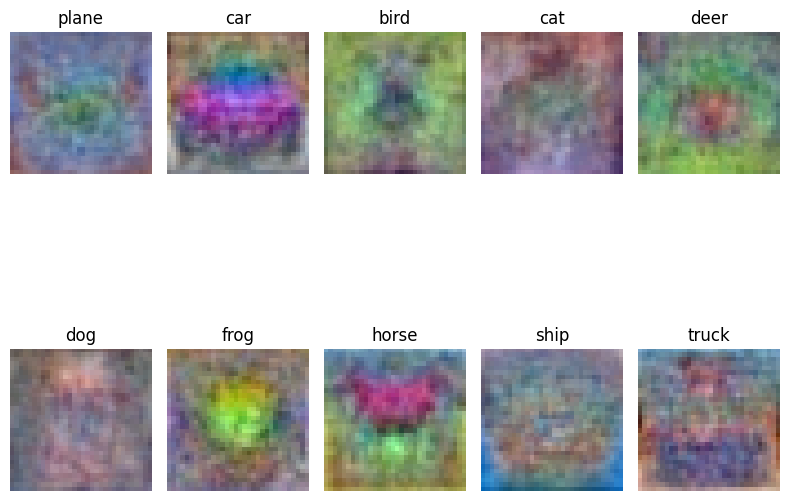

Visualizing weights for model5:


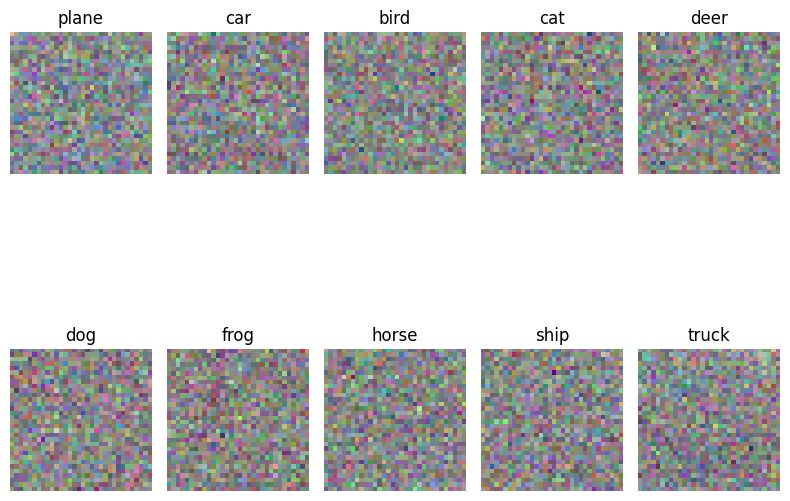

In [ ]:
# YOUR CODE HERE for visualizing model1, ..., model5
# comment on what patterns you see
# Are the coefficients of the best performing model more interpretable than the others?
print(visualize_model(model1))
for model_name, model in trained_models.items():
    print(f"Visualizing weights for {model_name}:")
    visualize_model(model)

Based on the results, model1 performed the best with a learning rate of 1e-2 and 1e-3. This shows that a moderate learning rate with a small weight decay performs best.  When the learning rate was too small, 1e-5, training was very slow and it led to the model being underfit. When the learning rate was too large, 1e-1, the model failed to converge properly. With a higher weight decay (1e-2), the model is over-regularized which reduces its performance.

Yes, the coefficient of model1 are more interpretable than the others. In model1's weight visualizations, there are some structured patterns, like blobs of color, or regions that roughly correspond to features of a class, e.g. the green-centered blobs in frog. On the other hand, for model5 with a low learning rate of 1e-5, the coefficients look almost like random noise. The model with heigher weight decay model3, the patterns are smoother so the regularization is likely suppressing some structure.for model4 with a high learning rate of 1e-1, the weights are somewhat structured but also still noisier and less stable.

# More error analysis
- visualize errors made by the model
- we show the visual confusion matrix between categories cat and dog
- feel free to look at misclassifications between any pair of categories (look at the confusion matrix to find the objects most confused with another)

In [ ]:
tmean = np.array([0.4914, 0.4822, 0.4465])
tstd = np.array([0.247, 0.243, 0.261])

def denormalize(img):
    """Undo CIFAR-10 normalization and convert to uint8 for imshow."""
    img = np.transpose(img, (1, 2, 0))           # CHW -> HWC
    img = (img * tstd + tmean) * 255.0
    return np.clip(img, 0, 255).astype(np.uint8)

# Get test data and predictions with model1

all_labels = []
all_preds = []
Xtest_list = [] # Use a list to store batches of test data

with torch.no_grad():
    for X,y in testloader:
        yhat = model1(X)
        Xtest_list.append(X) # Append test data batches
        all_labels.append(y)
        all_preds.append(yhat.argmax(dim=1))

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)
Xtest = torch.cat(Xtest_list) # Concatenate the list of batches


# Change cl_a and cl_b based on your  confusion matrix
# For example, from the confusion matrix of model1, classes 3 (cat) and 5 (dog) are confused

cl_a, cl_b = 3, 5 # Integer class labels

X_aa = Xtest[(all_labels == cl_a) & (all_preds == cl_a)]
X_ab = Xtest[(all_labels == cl_a) & (all_preds == cl_b)]
X_ba = Xtest[(all_labels == cl_b) & (all_preds == cl_a)]
X_bb = Xtest[(all_labels == cl_b) & (all_preds == cl_b)]

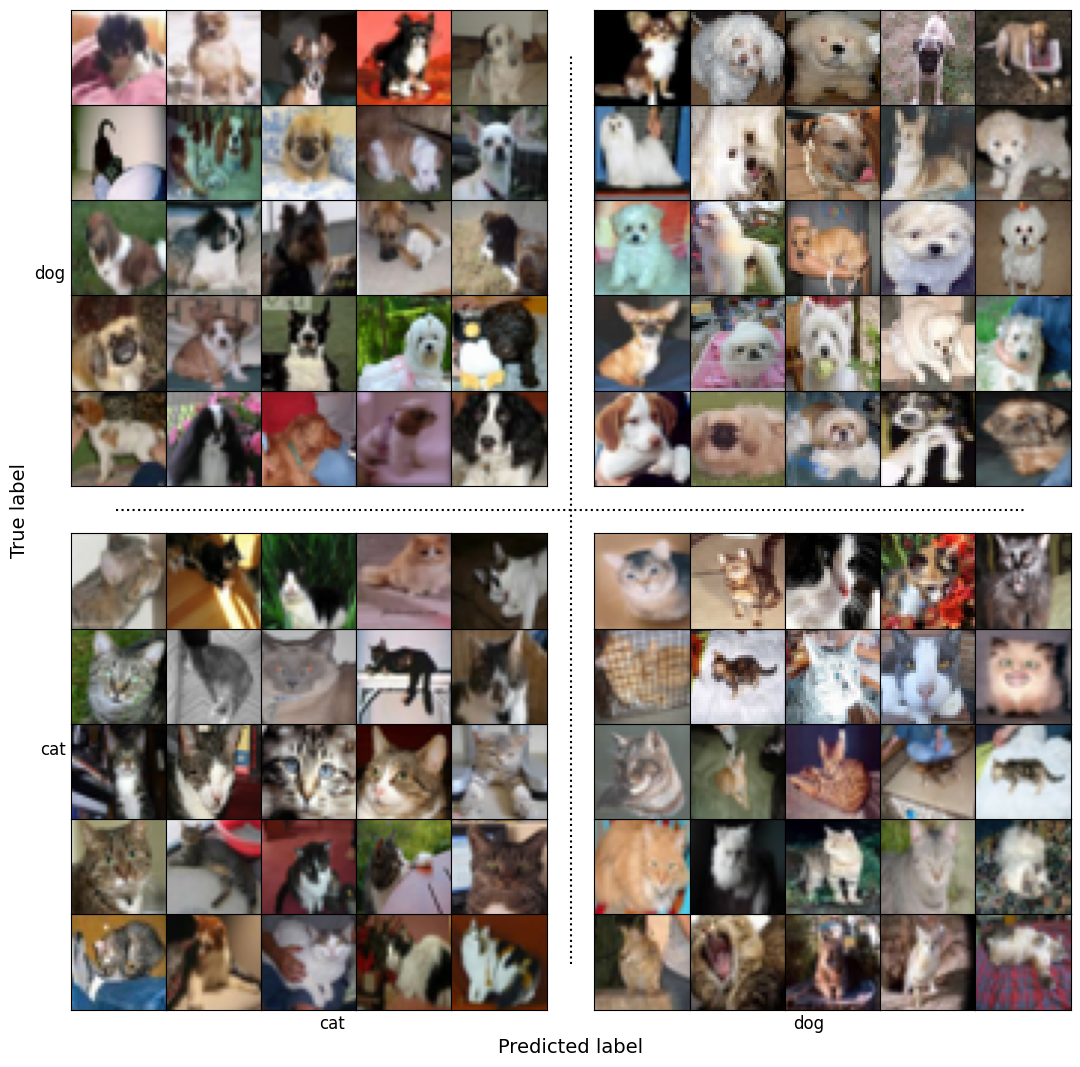

In [ ]:
size = 5   # grid size inside each confusion block
pad = 0.5  # spacing between quadrants
total = 2 * size + pad  # logical grid size

fig = plt.figure(figsize=(size*2, size*2))

# Loop through quadrants
for images, (true_row, pred_col) in [
    (X_aa, (0, 0)),  # true A, pred A
    (X_ab, (0, 1)),  # true A, pred B
    (X_ba, (1, 0)),  # true B, pred A
    (X_bb, (1, 1)),  # true B, pred B
]:
    for idx, image_data in enumerate(images[:size*size]):
        # Grid position in "data units"
        x = idx % size + pred_col * (size + pad)
        y = idx // size + true_row * (size + pad)

        # Normalize to figure coords [0,1]
        ax = fig.add_axes([x / total,
                           y / total,
                           1 / total,
                           1 / total])

        img = denormalize(image_data.numpy())
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

# Add invisible overlay axis (in figure space)
ax_main = fig.add_axes([0, 0, 1, 1], frameon=False)
ax_main.set_xticks([ (size/2)/total, (size+pad+size/2)/total ])
ax_main.set_xticklabels([classes[cl_a], classes[cl_b]], fontsize=12)

ax_main.set_yticks([ (size/2)/total, (size+pad+size/2)/total ])
ax_main.set_yticklabels([classes[cl_a], classes[cl_b]], fontsize=12)

ax_main.set_xlabel("Predicted label", fontsize=14)
ax_main.set_ylabel("True label", fontsize=14)

# Hide tick marks and spines
ax_main.tick_params(axis='both', which='both', length=0)
for spine in ax_main.spines.values():
    spine.set_visible(False)

# Divider lines in normalized coords
ax_main.plot([ (size+pad/2)/total, (size+pad/2)/total ], [0,1], "k:")
ax_main.plot([0,1], [ (size+pad/2)/total, (size+pad/2)/total ], "k:")

plt.show()

# Comment below on the types of errors made by the model using the visualization above. What are common characteristics among dogs mistaken for cats and vice versa?

Many of the cat images that were predicted as dogs are close-up facial shots with a little background context or cats in unusual poses. The dark-colored cats also seem harder for the model since their features blend into the background.

For many of the misclassified dogs are small breeds that have faces or body proportions similar to those of cats. Several of them are sitting or lying down in ways similar to the way cats do, and some have pointed ears or slender bodies that also make it confusing.